# Camera Calibration

* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html
* https://www.mathworks.com/help/vision/ug/camera-calibration.html
* http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html

<!--NAVIGATION-->

<a href="https://colab.research.google.com/github/yongduek/cvip//blob/master/camera_calib.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


In [98]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,5)
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
print ('OpenCV version: ', cv.__version__)

OpenCV version:  4.1.1


## Create Calibration Pattern
* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html

Now, if you want to create your own pattern, you will need python to use https://github.com/opencv/opencv/blob/master/doc/pattern_tools/gen_pattern.py

```    
python gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20


python gen_pattern.py -o circleboard.svg --rows 7 --columns 5 --type circles --square_size 15
 
python gen_pattern.py -o acircleboard.svg --rows 7 --columns 5 --type acircles --square_size 10 --radius_rate 2
```

In [2]:
# run the script to get an svg image file
!python3 opencv-doc/pattern_tools/gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20

In [3]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
drawing = svg2rlg('chessboard.svg')
renderPDF.drawToFile (drawing, 'chesspoard.pdf')

---
## Camera Calibration
---
- https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

<img src="camcal/1.png">
<img src="camcal/2.png">

Thus, if an image from the camera is scaled by a factor, all of these parameters should be scaled (multiplied/divided, respectively) by the same factor. The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene, or vice versa, rigid motion of an object in front of a still camera. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when z \ne 0 ):

<img src="camcal/3.png">

**Pin-hole Camera Model**

<img src="camcal/pinhole_camera_model.png">

Real lenses usually have some distortion, mostly radial distortion and slight tangential distortion. So, the above model is extended as:

<img src="camcal/4.png">

The next figure shows two common types of radial distortion: barrel distortion (typically $k_1 > 0$ and pincushion distortion (typically $k_1 < 0$).

<img src="camcal/5.png">

default distort_parameters = $[k_1, k_2, p_1, p_2, k_3]$

### First, set the size of the pattern and its corresponding World coordinates

In [3]:
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) ...
patternSize = (9,6)
objp = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
objp[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
print (objp[0:10])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]]


### Image detection of the chessboard corners.

In [4]:
import sys, os
dirname = 'opencv_samples_data'
try:
    os.makedirs(dirname)
except:
    pass

In [68]:
for i in range(1,15):
    cmd = "curl -o {}/left{:02d}.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left{:02d}.jpg".format(dirname, i, i)
    print (cmd)
    os.system(cmd)
#
#os.listdir(dirname)

curl -o opencv_samples_data/left01.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left01.jpg
curl -o opencv_samples_data/left02.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left02.jpg
curl -o opencv_samples_data/left03.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left03.jpg
curl -o opencv_samples_data/left04.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left04.jpg
curl -o opencv_samples_data/left05.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left05.jpg
curl -o opencv_samples_data/left06.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left06.jpg
curl -o opencv_samples_data/left07.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left07.jpg
curl -o opencv_samples_data/left08.jpg https://raw.githubusercontent.com/opencv/opencv/master/samples/data/left08.jpg
curl -o opencv_samples_data/left09.jpg https://raw.githu

In [5]:
import glob
imagefiles = sorted(glob.glob('opencv_samples_data/left??.jpg'))
imagefiles

['opencv_samples_data\\left01.jpg',
 'opencv_samples_data\\left02.jpg',
 'opencv_samples_data\\left03.jpg',
 'opencv_samples_data\\left04.jpg',
 'opencv_samples_data\\left05.jpg',
 'opencv_samples_data\\left06.jpg',
 'opencv_samples_data\\left07.jpg',
 'opencv_samples_data\\left08.jpg',
 'opencv_samples_data\\left09.jpg',
 'opencv_samples_data\\left11.jpg',
 'opencv_samples_data\\left12.jpg',
 'opencv_samples_data\\left13.jpg',
 'opencv_samples_data\\left14.jpg']

In [6]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
for i, fname in enumerate(imagefiles):
    print ('processing: ', fname)
    img = cv.imread(fname)
    if img is None:
        continue
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, patternSize=patternSize)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, patternSize=patternSize, corners=corners2, patternWasFound=ret)
        cv.imshow('img', img)
        outfname = f'results/calib-pattern-res-{i:02d}.png'
        cv.imwrite(outfname, img)
        print ('   --> ', outfname)
        cv.waitKey(500)
    else:
        print ('   --> skip.')
cv.destroyAllWindows()

processing:  opencv_samples_data\left01.jpg
   -->  results/calib-pattern-res-00.png
processing:  opencv_samples_data\left02.jpg
   -->  results/calib-pattern-res-01.png
processing:  opencv_samples_data\left03.jpg
   -->  results/calib-pattern-res-02.png
processing:  opencv_samples_data\left04.jpg
   -->  results/calib-pattern-res-03.png
processing:  opencv_samples_data\left05.jpg
   -->  results/calib-pattern-res-04.png
processing:  opencv_samples_data\left06.jpg
   -->  results/calib-pattern-res-05.png
processing:  opencv_samples_data\left07.jpg
   -->  results/calib-pattern-res-06.png
processing:  opencv_samples_data\left08.jpg
   -->  results/calib-pattern-res-07.png
processing:  opencv_samples_data\left09.jpg
   -->  results/calib-pattern-res-08.png
processing:  opencv_samples_data\left11.jpg
   -->  results/calib-pattern-res-09.png
processing:  opencv_samples_data\left12.jpg
   -->  results/calib-pattern-res-10.png
processing:  opencv_samples_data\left13.jpg
   -->  results/calib

In [7]:
ip = imgpoints[-1].copy()
print(ip.shape)
ip = ip.reshape(ip.shape[0], ip.shape[2])
print(ip.shape, ip[0])

(54, 1, 2)
(54, 2) [416.2941    57.344814]


### Let's see the image locations of the world orgin, x-axis, and y-axis points.

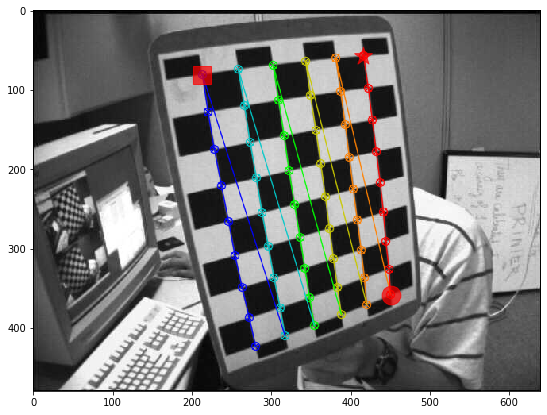

In [8]:
plt.figure(figsize=(10,7))
plt.imshow (img[:,:,::-1]) # BGR -> RGB for plt.imshow()
i = 0 # The world origin
plt.scatter(ip[i,0], ip[i,1], marker='*', color='r', s=350, alpha=0.7)
# The end tip of x-axis
i = patternSize[0] - 1  
plt.scatter(ip[i,0], ip[i,1], marker='o', color='r', s=350, alpha=0.7)
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
plt.scatter(ip[i,0], ip[i,1], marker='s', color='r', s=350, alpha=0.7)

Now we can see that the z-axis of the world goes down towards the person from the origin.

### Calibration
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, `cv.calibrateCamera()` which returns the camera matrix, distortion coefficients, rotation and translation vectors etc. 

In [9]:
ret, Kmat, distCoeff, rvecs, tvecs = cv.calibrateCamera(objpoints, 
                                                  imgpoints, 
                                                  imageSize=gray.shape[::-1], 
                                                  cameraMatrix=None, distCoeffs=None)

In [10]:
Kmat

array([[536.07343019,   0.        , 342.37038791],
       [  0.        , 536.01634475, 235.53685635],
       [  0.        ,   0.        ,   1.        ]])

In [11]:
distCoeff

array([[-0.26509006, -0.0467439 ,  0.00183301, -0.00031471,  0.25231586]])

In [12]:
rvecs[:2]

[array([[0.16853568],
        [0.27575314],
        [0.01346807]]), array([[ 0.41306755],
        [ 0.64934521],
        [-1.3371948 ]])]

In [13]:
tvecs[:2]

[array([[-3.01118544],
        [-4.35756677],
        [15.99287288]]), array([[-2.3455136 ],
        [ 3.31931519],
        [14.15396033]])]

### Re-projection Test

In [14]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj.shape

(54, 1, 2)

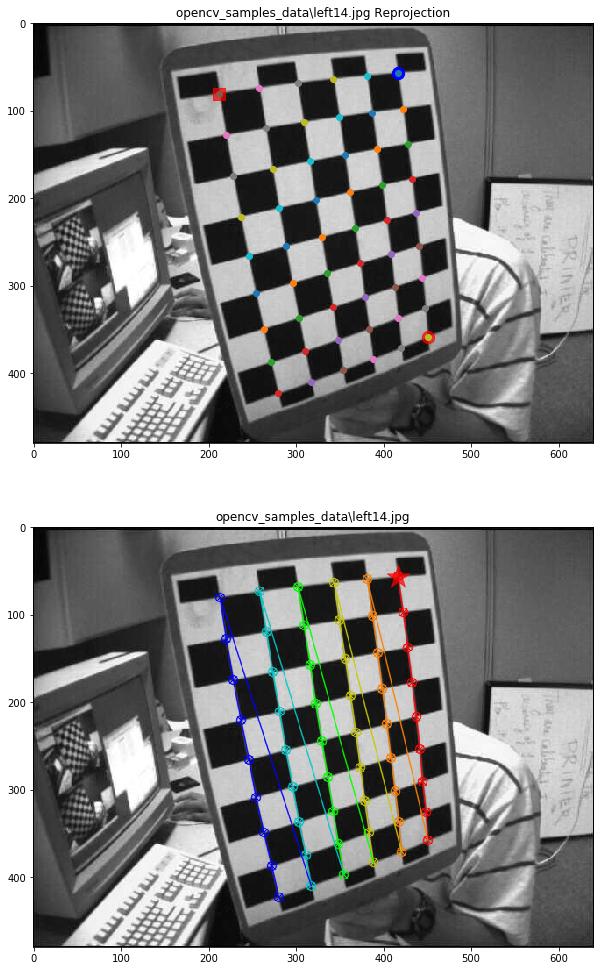

In [15]:
fig, ax = plt.subplots(2,1, figsize=(15,17))

simg = cv.imread(imagefiles[-1])   # read image
ax[0].imshow(simg[:,:,::-1])       # show
ax[0].set_title(imagefiles[-1] + ' Reprojection')
i = 0 # The origin point
ax[0].scatter(proj[0,0,0], proj[0,0,1], marker='o', color='b', s=150)  # projection of the origin
i = patternSize[0] - 1  # The end of the x-axis
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='o', color='r', s=150, alpha=0.7) # projection of x-axis
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='s', color='r', s=150, alpha=0.7) # projection of y-axis
#

pp = proj.reshape(-1, 2)    # other points
for xy in pp:
    ax[0].scatter(xy[0], xy[1])

# Second image Show
ax[1].set_title(imagefiles[-1])
ax[1].imshow(img[:,:,::-1])
i = 0 # The world origin
ax[1].scatter(ip[i,0], ip[i,1], marker='*', color='r', s=550, alpha=0.7)

### Reprojection Step-by-step

In [16]:
X3dW = objpoints[0].T
X3dW.shape

(3, 54)

In [17]:
X3dW[:,:7]

array([[0., 1., 2., 3., 4., 5., 6.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

**Rotation**

Conversion of rvec to R mat:

<img src="camcal/rodrigues_eq.png">

In [18]:
# we consider the last view
Rmat, _ = cv.Rodrigues(rvecs[-1])
Rmat

array([[ 0.14628383, -0.89499701, -0.42140407],
       [ 0.96235226,  0.22739733, -0.1488912 ],
       [ 0.22908334, -0.38375878,  0.89456695]])

In [19]:
Xc = Rmat @ X3dW
Xc[:,:4]

array([[0.        , 0.14628383, 0.29256765, 0.43885148],
       [0.        , 0.96235226, 1.92470451, 2.88705677],
       [0.        , 0.22908334, 0.45816667, 0.68725001]])

**Translation**

In [20]:
print ('translation vector:\n', tvecs[-1], tvecs[-1].shape)

translation vector:
 [[ 1.79855734]
 [-4.32644224]
 [12.50141672]] (3, 1)


In [21]:
Xc = Xc + tvecs[-1]
Xc[:,:4]

array([[ 1.79855734,  1.94484117,  2.09112499,  2.23740882],
       [-4.32644224, -3.36408998, -2.40173772, -1.43938547],
       [12.50141672, 12.73050006, 12.9595834 , 13.18866673]])

**Projection**

In [22]:
zc = Xc[2,:]
Xc = Xc / zc # [x/z, y/z, 1]
Xc[:, :4]

array([[ 0.14386828,  0.15277021,  0.16135742,  0.16964632],
       [-0.34607616, -0.26425435, -0.18532523, -0.10913806],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Lens distortion**

<img src="camcal/4.png">

distCoeff =  $[k_1, k_2, p_1, p_2, k_3]$

In [23]:
distCoeff 

array([[-0.26509006, -0.0467439 ,  0.00183301, -0.00031471,  0.25231586]])

In [24]:
def lens_distort(xyarr, dc):
    distorted = xyarr.copy()
    k1,k2,p1,p2,k3 = dc
    for dxy, xy in zip(distorted.T, xyarr.T):
        #print (xy, "--")
        r2 = xy[0]**2 + xy[1]**2
        radial = (1 + k1*r2 + k2*np.power(r2,2) + k3*np.power(r2,3)) #
        dxy[0] = xy[0] * radial + 2*p1*xy[0]*xy[1] + p2*(r2 + 2*xy[0]**2)
        dxy[1] = xy[1] * radial + p1*(r2 + 2*xy[1]**2) + 2*p2*xy[0]*xy[1]
        
    #
    return distorted
#

Xdistorted = lens_distort(Xc, distCoeff[0])
Xdistorted[:,:4]

array([[ 0.13823931,  0.14877424,  0.15861109,  0.16770734],
       [-0.33238448, -0.25722225, -0.1820821 , -0.10782431],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Image Scaling and Translation** : transform to pixel space

In [25]:
Ximg = Kmat @ Xdistorted
Ximg[:, :4]

array([[416.47680687, 422.12430365, 427.39757859, 432.27383864],
       [ 57.37334325,  97.66152586, 137.93787462, 177.7412635 ],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

#### Comparison

In [26]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj = proj.reshape(-1,2).T
proj[:,:4]

array([[416.4768  , 422.1243  , 427.39758 , 432.27383 ],
       [ 57.373344,  97.66153 , 137.93788 , 177.74126 ]], dtype=float32)

In [27]:
myProj = Ximg[:2, :]
myProj[:,:4]

array([[416.47680687, 422.12430365, 427.39757859, 432.27383864],
       [ 57.37334325,  97.66152586, 137.93787462, 177.7412635 ]])

In [28]:
dist = myProj - proj

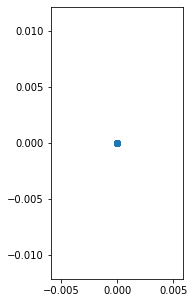

In [29]:
fig, ax = plt.subplots()
ax.scatter (dist[0,:], dist[1,:])
ax.set_aspect('equal')

Text(0.5, 1.0, 'distance between my projection and opencv-projection (in pixel unit)')

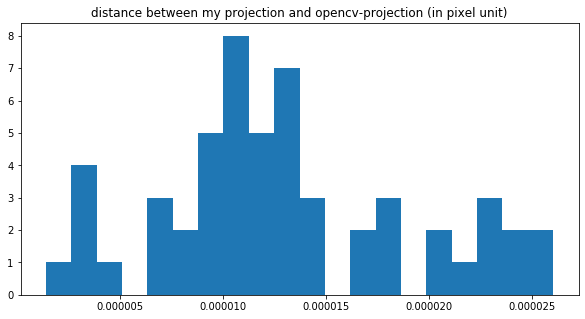

In [30]:
d_l2 = np.abs(dist[0]) + np.abs(dist[1])
plt.hist(d_l2, bins=20)
plt.title('distance between my projection and opencv-projection (in pixel unit)')

So our step-by-step projection gives the same output as cv.reprojection within the numerical computation error.

### Reprojection Error

In [31]:
# compute the total reprojection error
total_rms = 0
for i in range(len(objpoints)):
    proj, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], Kmat, distCoeff)
    error = imgpoints[i] - proj
    error = error.reshape(-1,2).T
    
    e2 = error[0]**2 + error[1]**2
    e2 = e2.sum()
    total_rms += e2
#
total_rms = np.sqrt(total_rms / (len(objpoints) * objpoints[0].shape[0]))

print( "total rms: {:.2f} pixels".format(total_rms))

total rms: 0.41 pixels


### Undistorted Image Computation

Text(0.5, 1.0, 'An image of the calibration pattern. Lens distortion is visible.')

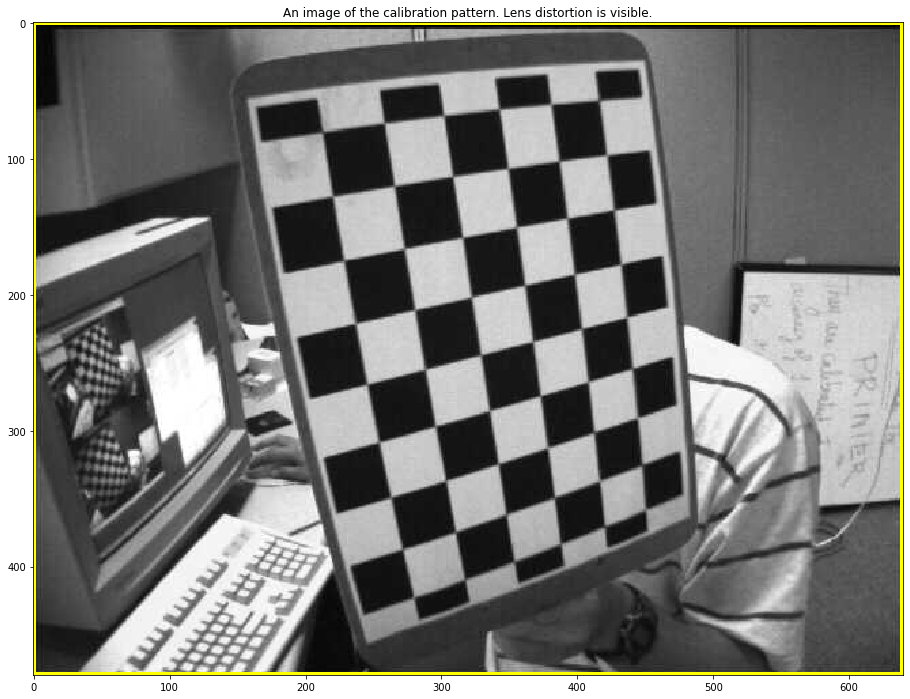

In [32]:
filename = 'left14-framed.png'
src = cv.imread(filename) # choose a file

plt.figure(figsize=(16, 12))
plt.imshow(src[:,:,::-1])
plt.title('An image of the calibration pattern. Lens distortion is visible.')

#### newKmat, validPixRoi = cv.getOptimalNewCameraMatrix()

The function computes and returns the optimal new camera matrix based on the free scaling parameter. 

By varying this parameter, you may retrieve 
1. only sensible pixels alpha=0
2. keep all the original image pixels if there is valuable information in the corners alpha=1 
3. or get something in between. When alpha>0

The undistortion result is likely to have some black pixels corresponding to “virtual” pixels outside of the captured distorted image. 

- **validPixROI** – Optional output rectangle that outlines all-good-pixels region in the undistorted image. (x, y, width, height)

In [33]:
h, w = src.shape[:2]
newKmat, roi = cv.getOptimalNewCameraMatrix (Kmat, distCoeff, imageSize=(w,h), alpha=1)
roi = np.array(roi)
roi

array([  4,  17, 625, 448])

In [34]:
newKmat

array([[469.45773315,   0.        , 341.99906721],
       [  0.        , 470.03921509, 236.70662232],
       [  0.        ,   0.        ,   1.        ]])

In [35]:
Kmat

array([[536.07343019,   0.        , 342.37038791],
       [  0.        , 536.01634475, 235.53685635],
       [  0.        ,   0.        ,   1.        ]])

**cv.undistort()**

In [36]:
undistorted = cv.undistort (src, Kmat, distCoeff, None, newKmat)
undistorted.shape
cv.imwrite("undistorted.png", undistorted)

True

Valid ROI Rectangle. 

OpenCV somehow determines this rectangle as a valid ROI in the undistorted image. It seems like the maximum rectangle fit inslide the undistorted boundary as can be seen in the image.

It is the same rectangle as the one obtained with `alpha=0` in `cv.getOptimalNewCameraMatrix()`.

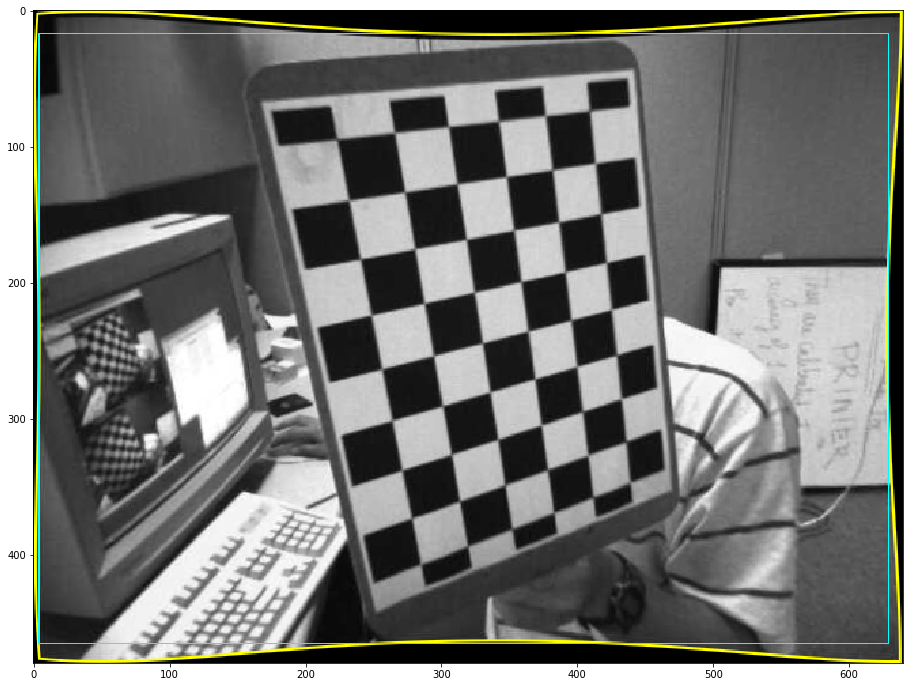

In [37]:
undistorted = cv.rectangle(undistorted, tuple(roi[:2]), tuple(roi[:2] + roi[2:]), (255,255,0), 1)
plt.figure(figsize=(16, 12))
plt.imshow(undistorted[:,:,::-1])

In [38]:
tuple(roi[:2])

(4, 17)

Text(0.5, 1.0, 'Undistorted Image')

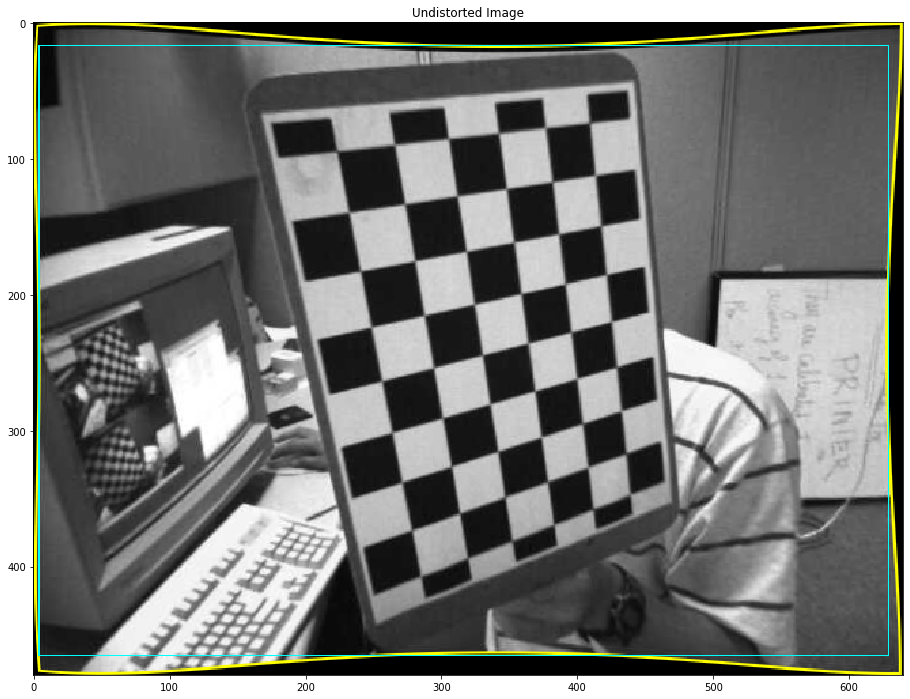

In [39]:
plt.figure(figsize=(16, 12))
plt.imshow(undistorted[:,:,::-1])
plt.title('Undistorted Image')

#### Pointwise undistortion

In [40]:
icorners = np.array([[[0.,0.]], [[0, w]], [[h, 0]], [[w,h]]])
un00 = cv.undistortPoints(icorners, Kmat, distCoeff, None, None, newKmat)
print (un00.reshape(-1,2), roi)

[[  2.31799221   1.86144106]
 [ 20.68817438 616.08638626]
 [473.11181105  11.8177314 ]
 [638.71435099 479.99999706]] [  4  17 625 448]


In [41]:
imgPun = cv.undistortPoints(imgpoints[-1], Kmat, distCoeff, None, None, newKmat)
imgPun = imgPun.reshape(-1,2)
imgP = imgpoints[-1].reshape(-1,2)

Text(0.5, 1.0, 'undistorted image and points: distCoef=[[-0.26509006 -0.0467439   0.00183301 -0.00031471  0.25231586]]')

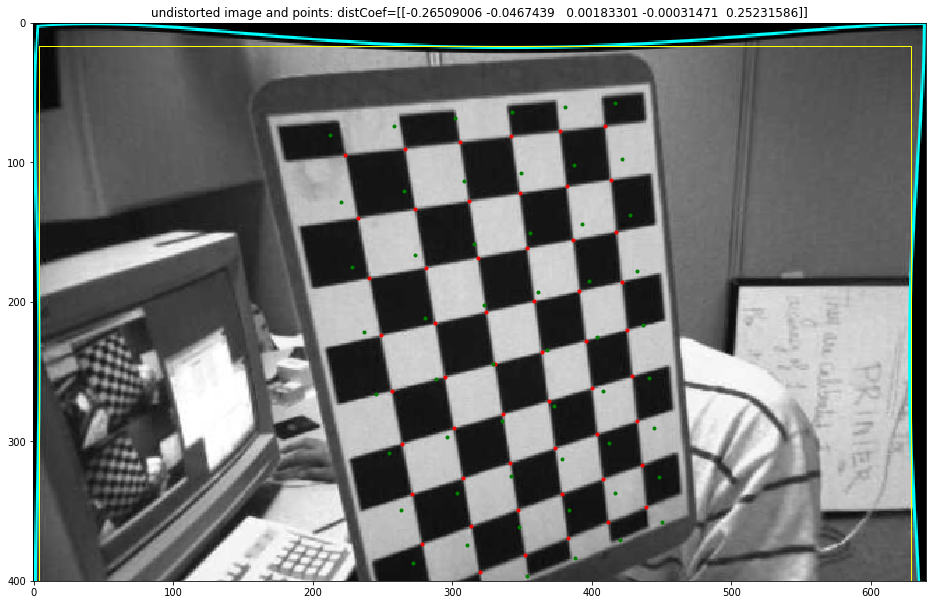

In [42]:
plt.figure(figsize=(16, 12))
plt.imshow(undistorted)
plt.scatter(imgPun[:,0], imgPun[:,1], c='r', marker='.') # undistorted points
plt.scatter(imgP[:,0], imgP[:,1], c='g', marker='.') # original points
plt.xticks(np.arange(0,img.shape[1],100))
plt.yticks(np.arange(0,img.shape[0],100))
plt.title ('undistorted image and points: distCoef={}'.format(distCoeff))

## Conclusion

Well, that's it.

When your camera seems to have lens distortion, then try to use this approach.

**Q. Take several photos of the calibration pattern and calibrate your phone's camera.**

# Rolling Shutter or Global Shutter

- [A good example is given here](https://www.premiumbeat.com/blog/know-the-basics-of-global-shutter-vs-rolling-shutter/)

![Global vs Rolling Shutter](camcal/Global-Shutter-vs-Rolling-Shutter.jpg)

---

# Camera Pose Estimation
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html
- [Perspective n Point Algorithm](https://en.wikipedia.org/wiki/Perspective-n-Point)
- See the notebook for [Camera Pose Estimation PnP Algorithms](camera_pose_pnp.ipynb)

In [43]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)

In [44]:
import os, glob
filelist = os.listdir('./opencv_samples_data/')
imgfiles = sorted(glob.glob('opencv_samples_data/right??.jpg'))
print (imgfiles)

['opencv_samples_data\\right01.jpg', 'opencv_samples_data\\right02.jpg', 'opencv_samples_data\\right03.jpg', 'opencv_samples_data\\right04.jpg', 'opencv_samples_data\\right05.jpg', 'opencv_samples_data\\right06.jpg', 'opencv_samples_data\\right07.jpg', 'opencv_samples_data\\right08.jpg', 'opencv_samples_data\\right09.jpg', 'opencv_samples_data\\right11.jpg', 'opencv_samples_data\\right12.jpg', 'opencv_samples_data\\right13.jpg', 'opencv_samples_data\\right14.jpg']


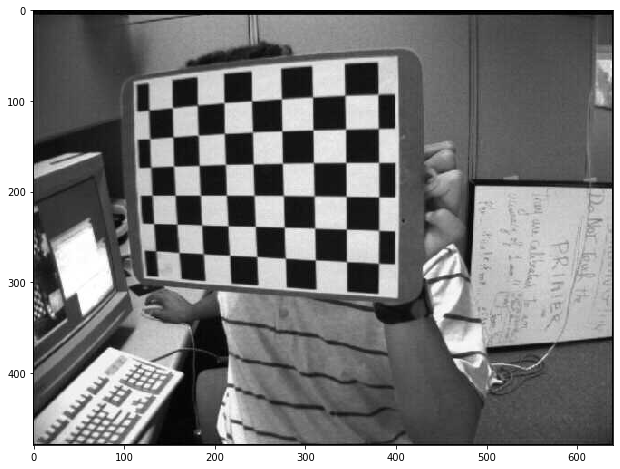

In [45]:
img = cv.imread(imgfiles[0])
plt.imshow (img[:,:,::-1])

## Find the corner points whose 3D coordinates are known.
- We use Chessboard image to make the correspondence problem easy, for educational purpose.

output from findChessboardCorners:
 [[128.52254  153.85231  181.46503  211.0593   241.50168  274.49753
  308.56372  344.08807  380.79593  128.84726  154.84007  182.10464
  211.38115  242.55681  274.6874   309.05255  344.68668  381.2796
  130.27171  155.2904   183.2957   212.50386  243.32832  275.4107
  309.24597  345.0577   381.57077  131.2451   157.2371   184.79799
  213.49461  244.09247  276.36542  310.3795   345.28876  381.56293
  133.16167  159.16682  186.38823  215.30037  245.39342  277.35098
  310.70178  345.59915  381.48465  135.68063  160.99942  187.80368
  217.01508  246.95517  278.54352  311.41403  346.05487  381.3015  ]
 [110.364685 107.58258  104.994896 102.56733  100.02284   98.17134
   96.18982   94.22975   93.25413  142.24522  139.96877  138.25333
  136.04436  134.53436  133.5681   132.28316  131.46538  130.8035
  173.26714  172.115    171.38748  170.32578  170.15369  169.3507
  168.34154  168.43813  168.43178  204.08716  204.22319  204.37473
  204.083    204.42982  204.

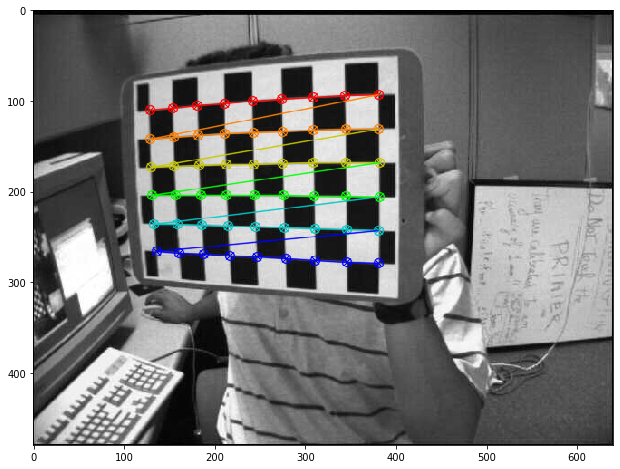

In [54]:
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
# Find the chess board corners
ret, corners = cv.findChessboardCorners(gray, patternSize=patternSize)
#
print ('output from findChessboardCorners:\n', corners.reshape(-1,2).T)
disp = img.copy()
cv.drawChessboardCorners(disp, patternSize=patternSize, corners=corners, patternWasFound=ret)
plt.imshow (disp[:,:,::-1])

## Compute the pose (R, T)

In [48]:
ret, rvec, tvec = cv.solvePnP (objp, corners, Kmat, distCoeff)

ret, rvec.T, tvec.T

(True,
 array([[0.15321782, 0.25179805, 0.00688   ]]),
 array([[-6.73680887, -3.96057855, 15.79987334]]))

## Project the 3D Obj points to image plane

### OpenCV tutorial version
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html

In [49]:
axis3d = np.float32([[3,0,0], [0,3,0], [0,0, -3]]).reshape(-1,3)

proj, jac = cv.projectPoints (axis3d, rvec, tvec, Kmat, distCoeff)

proj.reshape(-1,2).T

array([[210.8273  , 131.57896 ,  62.931786],
       [102.39156 , 204.39049 , 104.90309 ]], dtype=float32)

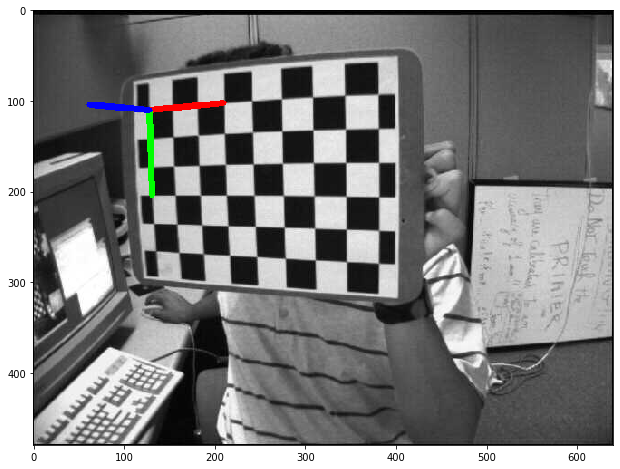

In [50]:
def draw(img, corners, imgpts):
    corner = tuple(corners[0].ravel())
    img = cv.line(img, corner, tuple(imgpts[0].ravel()), (255,0,0), 5)
    img = cv.line(img, corner, tuple(imgpts[1].ravel()), (0,255,0), 5)
    img = cv.line(img, corner, tuple(imgpts[2].ravel()), (0,0,255), 5)
    return img
#
disp2 = draw(img.copy(), corners, proj)
plt.imshow (disp2)

## Step by Step

### Project 3D cordinate frame with the camera intrinsic and extrinsic.

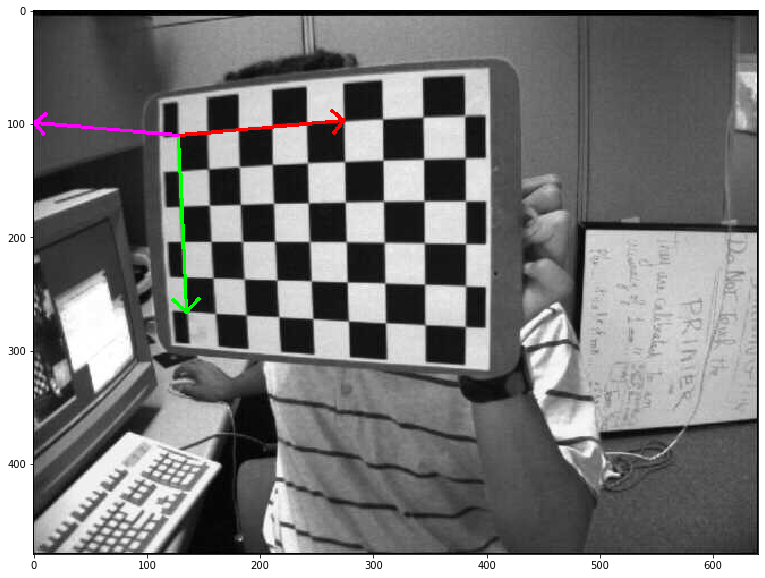

In [97]:
axis3d = np.float32([[0,0,0], [5,0,0], [0,5,0], [0,0, -5]]).reshape(-1,3) # Origin, X, Y, -Z

proj, jac = cv.projectPoints (axis3d, rvec, tvec, Kmat, distCoeff)

proj = proj.reshape(-1,2)
disp3 = img.copy()
disp3 = cv.arrowedLine(disp3, tuple(proj[0]), tuple(proj[1]), (255,0,0), 2) # red
disp3 = cv.arrowedLine(disp3, tuple(proj[0]), tuple(proj[2]), (0,255,0), 2) # green
disp3 = cv.arrowedLine(disp3, tuple(proj[0]), tuple(proj[3]), (255,0,255), 2) # -Z axis

plt.figure(figsize=(15,10))
plt.imshow(disp3)

## Process of cv::solvePnP()
1. undo `Kmat`
2. undo `distCoeff` (https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html#undistortpoints)
3. compute 'R' and 'T' using 2D-3D correspondences.

In [64]:
# make homogeneous coordinates
p2 = corners.reshape(-1,2).T
print (p2.shape)
ones = np.ones(p2.shape[1])
print (ones.shape)
p2h = np.vstack( (p2, ones) )
print (p2h.shape)

(2, 54)
(54,)
(3, 54)


In [73]:
# undo Kmat
iKmat = np.linalg.inv(Kmat)
print (iKmat, iKmat.shape)

p2hp = iKmat @ p2h

[[ 0.00186542  0.         -0.63866323]
 [ 0.          0.00186561 -0.43942103]
 [ 0.          0.          1.        ]] (3, 3)


In [90]:
# undistort
up2hp = cv.undistortPoints(p2hp[:2,:].T, np.eye(3,dtype=np.float64), distCoeff)

up2hp = up2hp.reshape(-1,2)
up2hp.shape, objp.shape, up2hp.dtype, objp.dtype, Kmat.dtype

((54, 2), (54, 3), dtype('float64'), dtype('float32'), dtype('float64'))

In [93]:
# Pose Estimation --> (R,T)
ret, rv, tv = cv.solvePnP(objp, up2hp, np.eye(3), np.zeros(distCoeff.shape))
ret, rv.T, tv.T

(True,
 array([[0.15318352, 0.25162525, 0.00682203]]),
 array([[-6.73712804, -3.96030905, 15.79995474]]))

See the outputs be the same as those values from the first try of cv.solvePnP()

In [96]:
rvec.T - rv.T, tvec.T - tv.T

(array([[3.43051780e-05, 1.72799949e-04, 5.79747592e-05]]),
 array([[ 3.19171067e-04, -2.69499831e-04, -8.13997248e-05]]))

### Undistort Algorithm

**Lens distortion**

<img src="camcal/4.png">

We have $x''$ and $y''$, and the goal is to obtain $x'$, $y'$ based on the two lens distortion equation.

From the lens distortion model as the 2D function $[f_x, f_y](x', y' |\theta)$ ($\theta$ = `distCoeff`) we can build up  an error function:

$$
    e_{x} = x'' - f_x(x', y' | \theta) \\
    e_{y} = y'' - f_y(x', y' |\theta)
$$

$$
    e^2 = e_{x}^2 + e_{y}^2
$$

Loss function
$$
    L(x', y') = e_i^2 (x', y')
$$

**Algorithm (Gradent Descent)**:

1. initialize: 
$$
    x' \leftarrow x'' \\
    y' \leftarrow y''
$$
2. Compute gradient:
$$
    g = [dL/dx', dL/dy'] \\
    \frac{dL}{dx'} = R + x' \frac{dR}{dx'} + 2p_1 y' + p_2\left(2r \frac{dr}{dx'} + 4x'\right)
$$
where 
$$
    r = \sqrt{ {x'}^2 + {y'}^2} \\
    \frac{dr}{dx'} = \frac{2 x'}{2r} = \frac{x'}{r} \\
    \frac{dr^2}{dx'} = 2 r \frac{dr}{dx'} \\
    \frac{dr^4}{dx'} = 4 r^3 \frac{dr}{dx'} \\
    \frac{dr^6}{dx'} = 6 r^5 \frac{dr}{dx'} \\
    R = 1 + k_1 r^2 + k_2 r^4 + k_3 r^6 \\
    \frac{dR}{dx'} = k_1 \frac{dr^2}{dx'} + k_2 \frac{dr^4}{dx'} + k_3\frac{dr^6}{dx'}
$$

3. Gradient Descent with learning rate $\lambda$:
$$
    x' \leftarrow x' - \lambda g_1  \\
    y' \leftarrow y' - \lambda g_2
$$

4. if $(x' - x'_p)^2 + (y' - y'_p)^2 < \epsilon$, stop; else go to step 2.

---
---

### Pose Estimation Algorithm

The goal is to obtain $r$, for $R(r)$ = Rodrigues$(r)$ = $[r_1^T; r_2^T; r_3^T]$ and $T$ the translation vector such that

$$
    z_i p_i = [R | T] [X_i; 1], \quad \mbox{ for } i = 1, ...
$$

where $p_i$ is a 2D image point in normalized image plane and $X_i$ is its corresponding 3D point; and 

$$
    z_i = r_3^T X_i + T_z
$$

is the depth of $p_i$.

**Error Loss Function**

$$
    L (r, T) 
        = \sum_{i=1}^N (x_i - \hat{x}_i)^2 + (x_i - \hat{y}_i)^2 \\
        = \sum_{i=1}^N (p_i - \hat{p}_i)^T (p_i - \hat{p}_i) \\
        = \sum_{i=1}^N e_i^T e_i \\
        = e^T e = (p - \hat{p})^T (p - \hat{p})
$$

**Gradient Computation**
$$
    g = \frac{d L}{d\theta} = \frac{d}{d\theta}(e^T e) = 2 \frac{de}{d\theta}^T e = 2 J^T e
$$

where 
$$
    J = \frac{de}{d\theta} = \frac{d}{d\theta} \big[ p - \hat{p} \big] = - \frac{d\hat{p}}{d\theta}
$$ 

is the jacobian matrix. This $\frac{d\hat{p}}{d\theta}$ can be obtained simply by calling the opencv function `cv.projectPoints()`, and using the first $2N\times 6$ submatrix of the returned jacobian.

See :
- https://docs.opencv.org/4.1.2/d9/d0c/group__calib3d.html#ga1019495a2c8d1743ed5cc23fa0daff8c
- imagePoints, jacobian	=	cv.projectPoints(	objectPoints, rvec, tvec, cameraMatrix, distCoeffs[, imagePoints[, jacobian[, aspectRatio]]]	)

**Rotation Parameterization**
$$
    R = R_0 R(r)
$$

$$
    \begin{bmatrix}
        \hat{x} \\
        \hat{y} \\
        1
    \end{bmatrix}
    = 
    \mathrm{Projection} \big[
        R_0 R(r) X + T
        \big]
$$

$$
    \frac{d\hat{x}}{dr_k} = ...
$$
    
**Algorithm**

1. Initialize:

$$
    r \leftarrow r_0 \\
    T \leftarrow T_0
$$

2. Compute Gradient $g$

3. Update by Gradient Descent
    $$
        r \leftarrow r - \lambda g_r \\
        T \leftarrow T - \lambda g_T
    $$


**Levenberg-Marquardt**

The loss function $L$ can be regarded as a function of $\delta$ around $\theta$ using Taylor expansion:

$$
    \hat{p}(\theta + \delta) = \hat{p}(\theta) + J \delta
$$

$$
\begin{align}
        L'(\delta) & = L(\theta + \delta)  \\
        &= [p - \hat{p}(\theta) - J \delta]^T [p - \hat{p}(\theta) - J \delta] \\
        &= [p - \hat{p}(\theta)]^T[p - \hat{p}(\theta)] - 2 [p - \hat{p}(\theta)]^T J\delta + \delta^TJ^TJ\delta
\end{align}
$$

Taking the derivative of $L'(\delta)$ with respect to $\delta$ and setting the result to zero gives:

$$
    (J^T J) \delta = J^T[ p - \hat{p}(\theta) ]
$$

This is a set of linear equations that can be solved for $\delta$ and $\theta \leftarrow \theta + \delta$.

Levenberg's algorithm is to replace this equation by a damped version:

$$
        (J^T J + \lambda) \delta = J^T[ p - \hat{p}(\theta) ]
$$

then

$$
    \theta \leftarrow \theta + \delta
$$


Later an updated version is reported:

$$
        \big(J^T J + \lambda\mathrm{diag}(J^T J)\big) \delta = J^T[ p - \hat{p}(\theta) ]
$$

which uses diagonal terms of $J^TJ$ instead of $I$ for faster convergence in the direction of small gradient. See [Levenberg-Marquardt algorithm](https://en.wikipedia.org/wiki/Levenberg%E2%80%93Marquardt_algorithm) in wikipedia.org.

---

END